# Aprendizaje Múltiple
**Nombre:** Juan Manuel Gutiérrez Gómez  **Código:** 2260563

Hemos visto cómo se puede usar el análisis de componentes principales (PCA) en la tarea de reducción de dimensionalidad, reduciendo la cantidad de características de un conjunto de datos mientras se mantienen las relaciones esenciales entre los puntos. Si bien PCA es flexible, rápido y fácil de interpretar, no funciona tan bien cuando existen relaciones no lineales dentro de los datos; veremos algunos ejemplos de estos a continuación.

Para abordar esta deficiencia, podemos recurrir a una clase de métodos conocidos como aprendizaje múltiple, una clase de estimadores no supervisados que busca describir conjuntos de datos como variedades de baja dimensión incrustadas en espacios de alta dimensión. Cuando piensas en una variedad, te sugiero que imagines una hoja de papel: este es un objeto bidimensional que vive en nuestro familiar mundo tridimensional y se puede doblar o enrollar en esas dos dimensiones. En el lenguaje del aprendizaje múltiple, podemos pensar en esta hoja como una variedad bidimensional incrustada en un espacio tridimensional.

Girar, reorientar o estirar la hoja de papel en un espacio tridimensional no cambia la geometría plana del papel: tales operaciones son similares a las incrustaciones lineales. Si dobla, riza o arruga el papel, sigue siendo una variedad bidimensional, pero la incrustación en el espacio tridimensional ya no es lineal. Múltiples algoritmos de aprendizaje buscarían aprender sobre la naturaleza bidimensional fundamental del papel, incluso cuando se retuerce para llenar el espacio tridimensional.

Aquí demostraremos una serie de métodos múltiples, profundizando en un par de técnicas: escalado multidimensional (MDS), incrustación lineal local (LLE) y mapeo isométrico (IsoMap).

Importamos las librerias que usaremos inicialemnte:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Aprendizaje múltiple: "HOLA" 

Para aclarar estos conceptos, comencemos generando algunos datos bidimensionales que podemos usar para definir una variedad. Aquí hay una función que creará datos con la forma de la palabra "HOLA":

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

Llamemos a la función y visualicemos los datos resultantes:

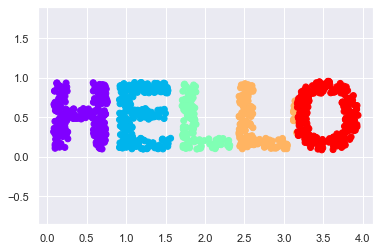

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

La salida es bidimensional y consta de puntos dibujados con la forma de la palabra "HOLA". Este formulario de datos nos ayudará a ver visualmente qué están haciendo estos algoritmos.

## Escalado multidimensional (MDS)

Al observar datos como este, podemos ver que la elección particular de los valores x e y del conjunto de datos no es la descripción más fundamental de los datos: podemos escalar, reducir o rotar los datos, y el "HOLA" seguirá siendo aparente. Por ejemplo, si usamos una matriz de rotación para rotar los datos, los valores de x e y cambian, pero los datos siguen siendo fundamentalmente los mismos:

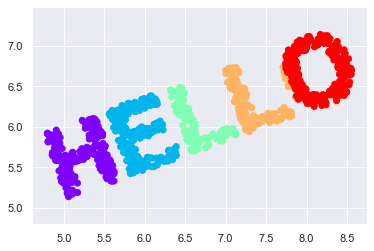

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

Esto nos dice que los valores de $x, y$ no son necesariamente fundamentales para las relaciones en los datos. Lo fundamental, en este caso, es la distancia entre cada punto y los demás puntos del conjunto de datos. Una forma común de representar esto es usar una matriz de distancia: para $N$ puntos, construimos una matriz $N * N$ tal que la entrada $(i,j)$ contiene la distancia entre el punto $i$ y el punto $j$. Usemos la eficiente función pairwise_distances de Scikit-Learn para hacer esto con nuestros datos originales:

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

Como prometimos, para nuestros N = 1000 puntos, obtenemos una matriz de 1000 × 1000, que se puede visualizar como se muestra aquí:

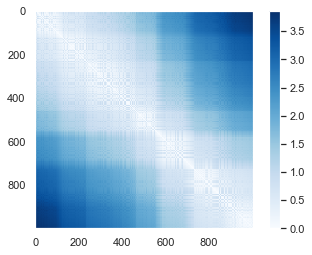

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.rcParams['axes.grid'] = False
plt.colorbar();

Si construimos de manera similar una matriz de distancia para nuestros datos rotados y trasladados, vemos que es lo mismo:

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

Esta matriz de distancia nos brinda una representación de nuestros datos que es invariable a las rotaciones y traslaciones, pero la visualización de la matriz anterior no es del todo intuitiva. En la representación que se muestra en esta figura, hemos perdido cualquier señal visible de la interesante estructura de los datos: el "HOLA" que vimos antes.

Además, mientras que calcular esta matriz de distancias a partir de las coordenadas (x, y) es sencillo, transformar las distancias nuevamente en coordenadas xey es bastante difícil. Esto es exactamente lo que pretende hacer el algoritmo de escalado multidimensional: dada una matriz de distancia entre puntos, recupera unaD-Representación de coordenadas dimensionales de los datos. Veamos cómo funciona para nuestra matriz de distancia, usando la disimilitud **precomputed** para especificar que estamos pasando una matriz de distancia:

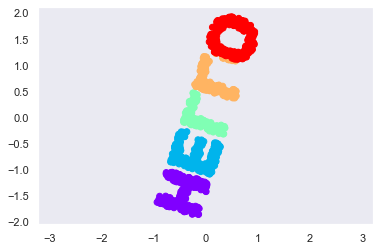

In [8]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

El algoritmo MDS recupera una de las posibles representaciones de coordenadas bidimensionales de nuestros datos, utilizando solo la matriz de distancia $N * N$ que describe la relación entre los puntos de datos.

## MDS como aprendizaje múltiple

La utilidad de esto se vuelve más evidente cuando consideramos el hecho de que las matrices de distancia se pueden calcular a partir de datos en cualquier dimensión. Entonces, por ejemplo, en lugar de simplemente rotar los datos en el plano bidimensional, podemos proyectarlos en tres dimensiones usando la siguiente función (esencialmente, una generalización tridimensional de la matriz de rotación utilizada anteriormente):

In [9]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

Visualicemos estos puntos para ver con qué estamos trabajando:

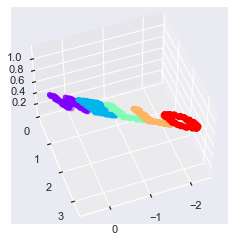

In [10]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

Ahora podemos pedirle al estimador MDSque ingrese estos datos tridimensionales, calcule la matriz de distancia y luego determine la incrustación bidimensional óptima para esta matriz de distancia. El resultado recupera una representación de los datos originales:

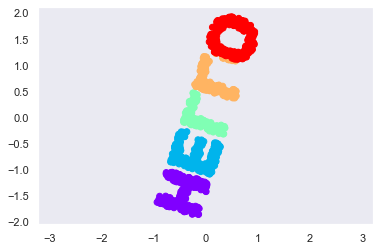

In [11]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

Este es esencialmente el objetivo de un estimador de aprendizaje múltiple: dados datos incrustados de alta dimensión, busca una representación de baja dimensión de los datos que preserva ciertas relaciones dentro de los datos. En el caso de MDS, la cantidad conservada es la distancia entre cada par de puntos.

## Embebidos no lineales: Donde MDS falla

Nuestra discusión hasta ahora ha considerado incrustaciones lineales, que esencialmente consisten en rotaciones, traslaciones y escalas de datos en espacios de mayor dimensión. Donde falla MDS es cuando la incrustación no es lineal, es decir, cuando va más allá de este simple conjunto de operaciones. Considere la siguiente incrustación, que toma la entrada y la contorsiona en forma de "S" en tres dimensiones:

In [12]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

Se trata nuevamente de datos tridimensionales, pero podemos ver que la incrustación es mucho más complicada:

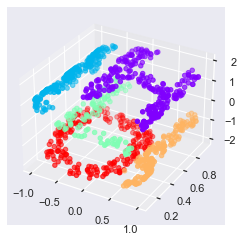

In [13]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

Las relaciones fundamentales entre los puntos de datos siguen ahí, pero esta vez los datos se han transformado de forma no lineal: se han envuelto en forma de "S".

Si probamos un algoritmo MDS simple con estos datos, no es capaz de "desenvolver" esta incrustación no lineal y perdemos el rastro de las relaciones fundamentales en la variedad incrustada:

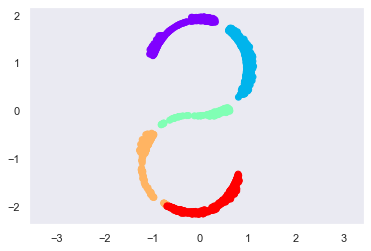

In [14]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

La mejor incrustación lineal bidimensional no desenvuelve la curva S, sino que descarta el eje *y* original.

## Variedades no lineales: incrustación localmente lineal

¿Cómo podemos avanzar aquí? Dando un paso atrás, podemos ver que la fuente del problema es que MDS intenta preservar las distancias entre los puntos lejanos al construir la incrustación. Pero, ¿y si en su lugar modificamos el algoritmo de modo que solo conserve las distancias entre puntos cercanos? La incrustación resultante estaría más cerca de lo que queremos.

Aquí, cada línea tenue representa una distancia que debe conservarse en la incrustación. A la izquierda hay una representación del modelo utilizado por MDS: intenta preservar las distancias entre cada par de puntos en el conjunto de datos. A la derecha hay una representación del modelo utilizado por un algoritmo de aprendizaje múltiple llamado incrustación lineal local (LLE): en lugar de preservar todas las distancias, intenta preservar solo las distancias entre puntos vecinos : en este caso, los 100 vecinos más cercanos de cada punto.

Pensando en el panel izquierdo, podemos ver por qué falla MDS: no hay forma de aplanar estos datos mientras se preserva adecuadamente la longitud de cada línea dibujada entre los dos puntos. Para el panel derecho, por otro lado, las cosas parecen un poco más optimistas. Podríamos imaginarnos desenrollando los datos de una manera que mantenga las longitudes de las líneas aproximadamente iguales. Esto es precisamente lo que hace LLE, a través de una optimización global de una función de costo que refleja esta lógica.

LLE viene en varios sabores; aquí usaremos el algoritmo LLE modificado para recuperar la variedad bidimensional incrustada. En general, LLE modificado funciona mejor que otras versiones del algoritmo para recuperar variedades bien definidas con muy poca distorsión:

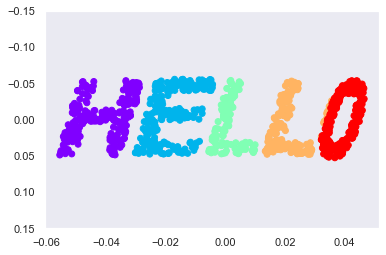

In [15]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

El resultado permanece algo distorsionado en comparación con nuestra variedad original, ¡pero captura las relaciones esenciales en los datos!

## Ejemplo: Isomap en Cara

Un lugar donde el aprendizaje múltiple se usa a menudo es para comprender la relación entre puntos de datos de alta dimensión. Un caso común de datos de alta dimensión son las imágenes: por ejemplo, un conjunto de imágenes con 1000 píxeles cada una puede considerarse como una colección de puntos en 1000 dimensiones: el brillo de cada píxel en cada imagen define la coordenada en esa dimensión.

Aquí vamos a aplicar Isomap en algunos datos de caras. Usaremos el conjunto de datos Labeled Faces in the Wild:

In [16]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

Tenemos 2.370 imágenes, cada una con 2.914 píxeles. En otras palabras, las imágenes se pueden considerar como puntos de datos en un espacio de 2914 dimensiones.

Visualicemos rápidamente varias de estas imágenes para ver con qué estamos trabajando:

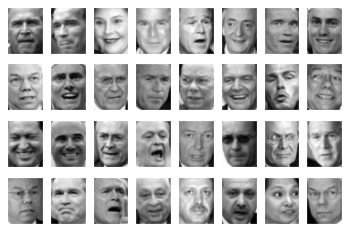

In [17]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Nos gustaría trazar una incrustación de baja dimensión de los datos de 2914 dimensiones para aprender las relaciones fundamentales entre las imágenes. Una forma útil de comenzar es calcular un PCA y examinar la relación de varianza explicada, lo que nos dará una idea de cuántas características lineales se requieren para describir los datos:

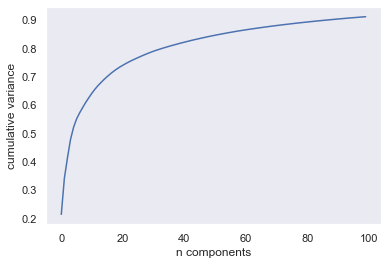

In [18]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

Vemos que para estos datos, se requieren casi 100 componentes para preservar el 90 % de la varianza: esto nos dice que los datos son intrínsecamente de muy alta dimensión, no se pueden describir linealmente con solo unos pocos componentes.

Cuando este es el caso, las incrustaciones múltiples no lineales como LLE e Isomap pueden ser útiles. Podemos calcular una incrustación de Isomap en estas caras usando el mismo patrón que se muestra antes:

In [19]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

La salida es una proyección bidimensional de todas las imágenes de entrada. Para tener una mejor idea de lo que nos dice la proyección, definamos una función que generará miniaturas de imágenes en las ubicaciones de las proyecciones:

In [20]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Llamando a esta función ahora, vemos el resultado:

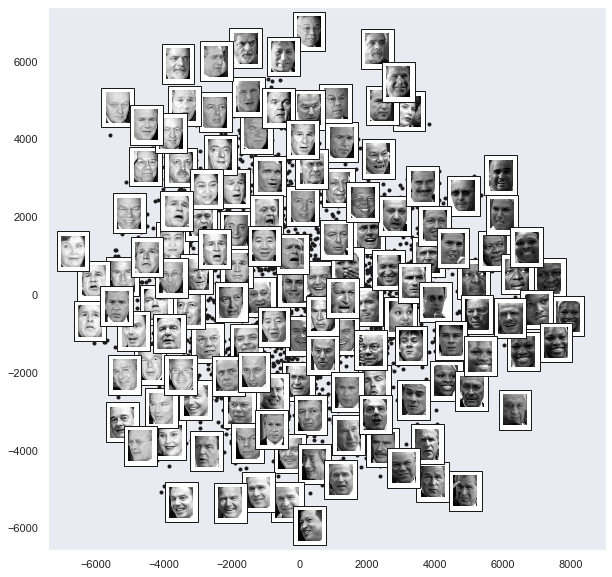

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

El resultado es interesante: las dos primeras dimensiones de Isomap parecen describir características globales de la imagen: la oscuridad o claridad general de la imagen de izquierda a derecha y la orientación general de la cara de abajo hacia arriba. Esto nos da una buena indicación visual de algunas de las características fundamentales de nuestros datos.

Luego podríamos pasar a clasificar estos datos (quizás usando múltiples características como entradas para el algoritmo de clasificación) como lo hicimos en Support Vector Machines.

## Ejemplo: Visualización de Estructura en Dígitos

Como otro ejemplo del uso del aprendizaje múltiple para la visualización, echemos un vistazo al conjunto de dígitos escritos a mano del MNIST. Estos datos son similares a los dígitos que vimos en **Decision Trees and Random Forests**, pero con muchos más píxeles por imagen.

In [22]:
from scipy.io import loadmat
mnist = loadmat('mnist-original.mat')
mdata=mnist['data'].T
mtarget=mnist['label'].T
mdata.shape

(70000, 784)

Este consta de 70.000 imágenes, cada una con 784 píxeles (es decir, las imágenes son 28×28). Como antes, podemos echar un vistazo a las primeras imágenes:

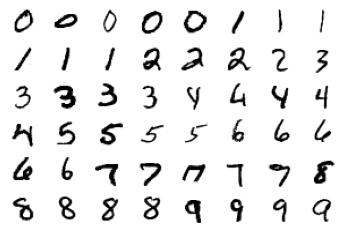

In [23]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mdata[1250 * i].reshape(28, 28), cmap='gray_r')

Esto nos da una idea de la variedad de estilos de escritura a mano en el conjunto de datos.

Calculemos una proyección de aprendizaje múltiple a través de los datos. Para la velocidad aquí, solo usaremos 1/30 de los datos, que son aproximadamente ~ 2000 puntos (debido a la escala relativamente pobre del aprendizaje múltiple, creo que unos pocos miles de muestras es un buen número para comenzar relativamente rápido la exploración antes de pasar a un cálculo completo):

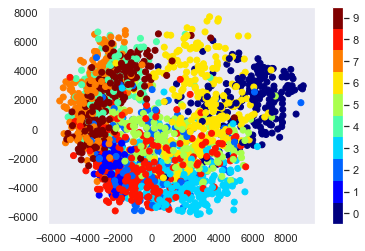

In [24]:
# use only 1/30 of the data: full dataset takes a long time!
data = mdata[::30]
target = mtarget[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

El diagrama de dispersión resultante muestra algunas de las relaciones entre los puntos de datos, pero está un poco abarrotado. Podemos obtener más información al observar un solo número a la vez:

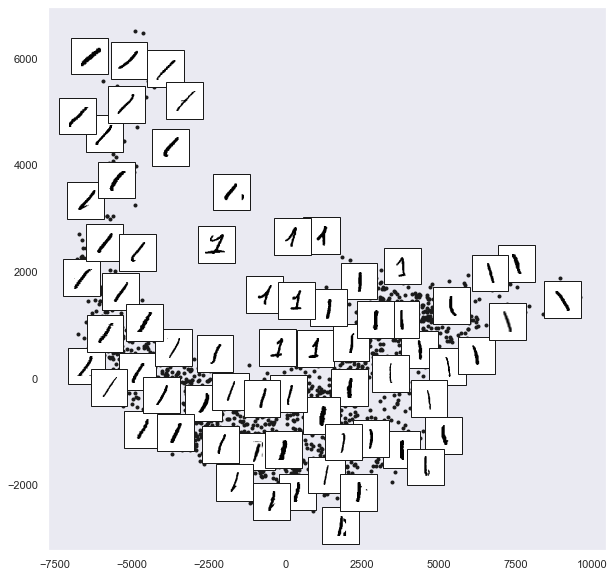

In [25]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
# data = mdata[[mtarget == 1]][::4]
data = mdata[np.array([mtarget == 1]).flatten()][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

El resultado le da una idea de la variedad de formas que puede tomar el número "1" dentro del conjunto de datos. Los datos se encuentran a lo largo de una amplia curva en el espacio proyectado, que parece seguir la orientación del dígito. A medida que avanza en la gráfica, encontrará algunos que tienen sombreros y/o bases, aunque estos son muy escasos dentro del conjunto de datos. La proyección nos permite identificar valores atípicos que tienen problemas de datos: por ejemplo, partes de los dígitos vecinos que se colaron en las imágenes extraídas.

Ahora, esto en sí mismo puede no ser útil para la tarea de clasificar dígitos, pero nos ayuda a comprender los datos y puede darnos ideas sobre cómo avanzar, por ejemplo, cómo podríamos querer preprocesar los datos antes. construcción de un canal de clasificación.

### **Conclusiones de los Ejercicios de Isomap:** 
Lo que empezo siendo un grupo de imágenes con una alta dimensionalidad por el número de píxeles, terminó en una clasificación simple de características como la oscuridad, claridad y lado de inclinación de la cara. Por otro lado, un dataset grande de dígitos escritos a mano con una alta dimensionalidad(por la tipografía de cada persona) se redujo a una interpretación de las diferentes formas de escritura del dígito 1.  En eso se basa Isomap y el Aprendizaje Múltiple, extraer la variedad de baja dimensión que se puede usar para describir los datos de alta dimensión. Aunque los puntos de datos pueden consistir en miles de características, pueden describirse como una función de solo unos pocos parámetros subyacentes.

## Conclusión General

Los métodos que están dentro de la categoría de Aprendizaje Múltiple son una mejora a las desventajas del PCA, pues los metodos de Manifold Learning tienen un carácter no lineal. Si piensa en enfoques como PCA, nos damos cuenta de que estamos proyectando los datos en una superficie de baja dimensión. Pero esto es restrictivo en el sentido de que esas superficies son todas lineales. Si nos enfrentamos a formas extrañas, PCA no haría bien el trabajo por su carácter lineal, contrario al aprendizaje múltiple que se basan en la idea de que la dimensionalidad de muchos conjuntos de datos es solo artificialmente alta.